<a href="https://colab.research.google.com/github/jhonesaly/ml-tools/blob/main/image-similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q annoy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import tensorflow_hub as hub

module_handle = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
module = hub.load(module_handle)

query_image_path = '/content/query_image.jpg'
query_img = load_img(query_image_path)
query_vec = np.squeeze(module(query_img))
print("Shape of the query image feature vector:", query_vec.shape)

Shape of the query image feature vector: (2048,)


In [ ]:
import tensorflow as tf
import numpy as np

def load_img(path):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.image.resize_with_pad(img, 224, 224)
  img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  return img

query_image_path = '/content/query_image.jpg'
query_img = load_img(query_image_path)
query_vec = np.squeeze(module(query_img))
print("Shape of the query image feature vector:", query_vec.shape)

Shape of the query image feature vector: (2048,)


In [ ]:
import zipfile
import os

dataset_zip_path = '/content/dataset.zip'
extracted_path = '/content/airplane_dataset'

# Create the extraction directory if it doesn't exist
os.makedirs(extracted_path, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

print(f"Dataset extracted to: {extracted_path}")

# Optional: List the contents of the extracted directory to verify
# for root, dirs, files in os.walk(extracted_path):
#     level = root.replace(extracted_path, '').count(os.sep)
#     indent = ' ' * 4 * (level)
#     print('{}{}/'.format(indent, os.path.basename(root)))
#     subindent = ' ' * 4 * (level + 1)
#     for f in files:
#         print('{}{}'.format(subindent, f))

Dataset extracted to: /content/airplane_dataset


In [ ]:
import glob
import os
from pathlib import Path

# Get all image paths from the extracted dataset directory
image_paths = []
for path in Path(extracted_path).rglob('*.jpg'):
  image_paths.append(path)

print(f"Found {len(image_paths)} images in the dataset.")

# Optional: Print the first few image paths to verify
# print("First 5 image paths:", image_paths[:5])

Found 100 images in the dataset.


In [ ]:
import numpy as np
import os
from tqdm import tqdm

# Create a directory to store the image feature vectors
imgvec_path = '/content/airplane_img_vectors/'
os.makedirs(imgvec_path, exist_ok=True)

# Load the encoder model if it's not already loaded
# Assuming 'module' is already loaded from a previous cell
# If not, you might need to add:
# import tensorflow_hub as hub
# module_handle = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
# module = hub.load(module_handle)


print(f"Generating feature vectors for {len(image_paths)} images...")

# Dictionary to store image name to feature vector mapping
image_name_to_vector = {}

for image_path in tqdm(image_paths):
    try:
        # Load and preprocess the image
        img = load_img(str(image_path))

        # Get the feature vector using the encoder
        features = module(img)
        feature_set = np.squeeze(features)

        # Extract the image file name without extension
        image_name = os.path.basename(image_path).split('.')[0]

        # Store the image name and its feature vector
        image_name_to_vector[image_name] = feature_set

        # Optional: Save the feature vector to a file (can be useful for large datasets)
        # outfile_name = image_name + ".npy" # Using .npy format for numpy arrays
        # out_path_file = os.path.join(imgvec_path, outfile_name)
        # np.save(out_path_file, feature_set)

    except Exception as e:
        print(f"Could not process image {image_path}: {e}")

print(f"Finished generating feature vectors for {len(image_name_to_vector)} images.")

Generating feature vectors for 100 images...


100%|██████████| 100/100 [00:19<00:00,  5.01it/s]

Finished generating feature vectors for 100 images.


In [ ]:
from annoy import AnnoyIndex
import pickle
import os
from tqdm import tqdm

# Configuring annoy parameters
dims = 2048  # The dimension of the feature vectors
trees = 100 # Number of trees to build in the index

# Create an Annoy index
indexer = AnnoyIndex(dims, metric='angular') # Using angular distance

# Dictionary to map Annoy index to image name
index_to_image_name = {}

print(f"Building Annoy index with {len(image_name_to_vector)} items...")

# Add items to the index
for i, (image_name, image_vector) in tqdm(enumerate(image_name_to_vector.items())):
    indexer.add_item(i, image_vector)
    index_to_image_name[i] = image_name

# Build the index
indexer.build(trees)

# Define path to save the index and mappings
index_save_path = '/content/airplane_index/'
os.makedirs(index_save_path, exist_ok=True)

# Save the index
indexer.save(os.path.join(index_save_path, 'airplane.ann'))

# Save the index to image name mapping
with open(os.path.join(index_save_path, 'index_to_image_name.pkl'), 'wb') as f:
    pickle.dump(index_to_image_name, f)

print(f"Annoy index built and saved to {index_save_path}")

Building Annoy index with 100 items...


100it [00:00, 3878.34it/s]

Annoy index built and saved to /content/airplane_index/


Query image loaded successfully from: /content/query_image.jpg


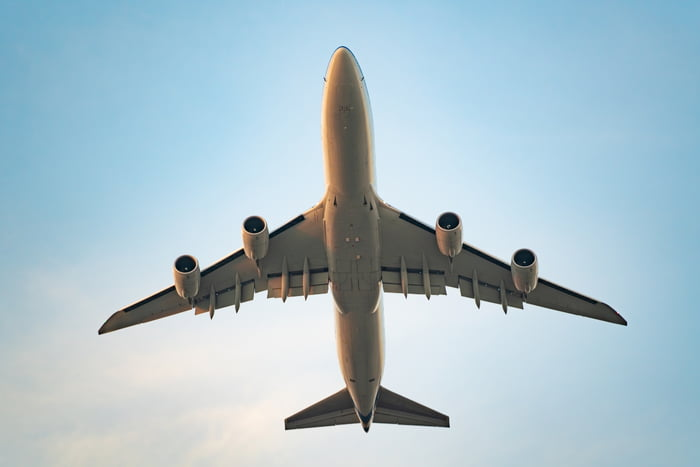

In [ ]:
from PIL import Image
import os

query_image_path = '/content/query_image.jpg'

# Check if the query image exists
if os.path.exists(query_image_path):
    query_image = Image.open(query_image_path)
    print(f"Query image loaded successfully from: {query_image_path}")
    # Display the query image
    display(query_image)
else:
    print(f"Error: Query image not found at {query_image_path}. Please upload your query image to the root of your Colab environment.")

In [ ]:
import numpy as np

# Assuming 'module' and 'load_img' are already defined in previous cells

query_image_path = '/content/query_image.jpg'
query_img = load_img(query_image_path)
query_vec = np.squeeze(module(query_img))

print("Shape of the query image feature vector:", query_vec.shape)

Shape of the query image feature vector: (2048,)


In [ ]:
from annoy import AnnoyIndex
import pickle
import os

# Assuming 'query_vec' is already generated and 'index_save_path' is defined

dims = 2048  # Should match the dimension used when building the index
index_path = os.path.join(index_save_path, 'airplane.ann')

# Load the Annoy index
indexer = AnnoyIndex(dims, 'angular')
indexer.load(index_path)

# Define the number of nearest neighbors to retrieve
topK = 4

# Get the nearest neighbors (indices and distances)
nns = indexer.get_nns_by_vector(query_vec, n=topK, include_distances=True)

print(f"Found {len(nns[0])} nearest neighbors:")
print("Indices:", nns[0])
print("Distances:", nns[1])

Found 4 nearest neighbors:
Indices: [15, 79, 76, 17]
Distances: [0.1192936822772026, 0.11932235211133957, 0.12211038172245026, 0.1322995275259018]


Displaying similar images:


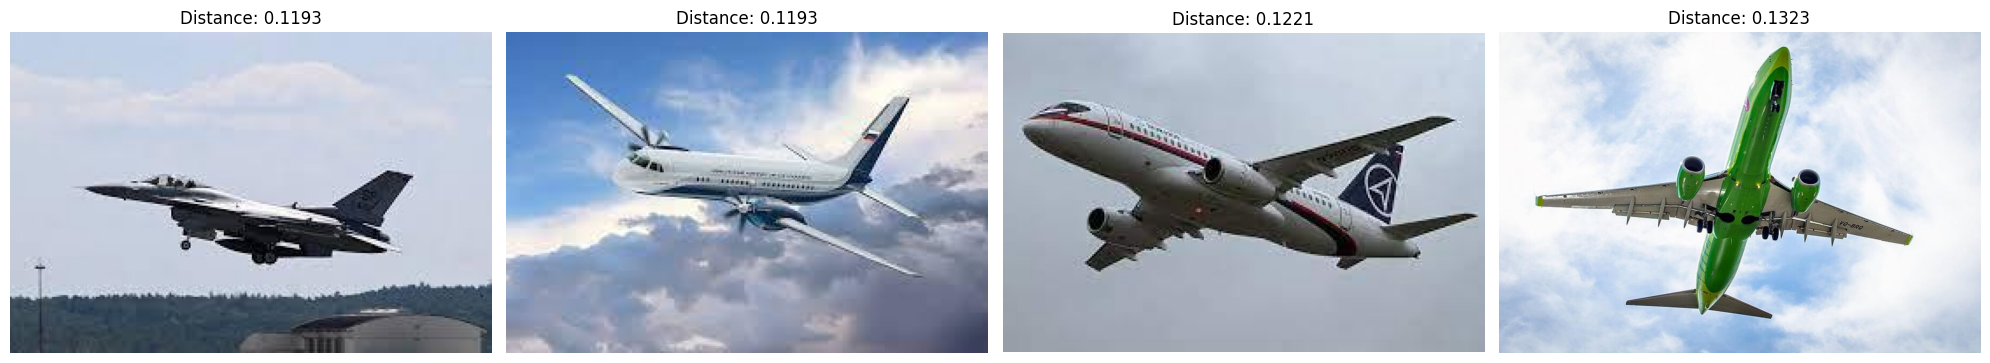

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pickle
import glob

# Assuming 'nns' (nearest neighbors indices and distances) and 'index_save_path' are defined

# Load the index to image name mapping
index_to_image_name_path = os.path.join(index_save_path, 'index_to_image_name.pkl')
with open(index_to_image_name_path, 'rb') as f:
    index_to_image_name = pickle.load(f)

# Get the image names and distances for the nearest neighbors
similar_image_indices = nns[0]
similar_image_distances = nns[1]

print("Displaying similar images:")

plt.figure(figsize=(20, 10))

# Base path where dataset images are located
image_base_path = '/content/airplane_dataset'

# List of potential subdirectories containing images
subdirs = ['train', 'test', 'valid']

for i in range(len(similar_image_indices)):
    index = similar_image_indices[i]
    distance = similar_image_distances[i]
    # Get the image name prefix from the mapping
    image_name_prefix = index_to_image_name[index]

    image_full_path = None
    # Search within the known subdirectories for a file starting with the prefix
    for subdir in subdirs:
        search_pattern = os.path.join(image_base_path, subdir, 'images', f"{image_name_prefix}.*jpg")
        found_files = glob.glob(search_pattern)
        if found_files:
            # Assuming there's only one file matching the pattern
            image_full_path = found_files[0]
            break # Found the image, no need to check other subdirs

    if image_full_path:
        plt.subplot(1, len(similar_image_indices), i + 1)
        plt.title(f"Distance: {distance:.4f}")
        img = mpimg.imread(image_full_path)
        plt.imshow(img)
        plt.axis('off')
    else:
        print(f"Warning: Image file with prefix '{image_name_prefix}' not found in {image_base_path} subdirectories.")

plt.tight_layout()
plt.show()